# Selection of optimal sketching size 

Select the optimal sketching size according to theorem 3.6 and then visualizing out-of-sample risk in theorem 3.2, with fixed n, varying p.

In [2]:
from sklearn.base import RegressorMixin

import numpy as np
import seaborn as sns

from scipy.stats import ortho_group # othogonal matrix

import os
import json, codecs

import matplotlib.pyplot as plt

from joblib import Parallel, delayed

# Sketched estimator and ridgeless estimator

In [ ]:
from scipy.fftpack import dct
import numpy as np

def generate_harr_matrix(n, p):
    if n <= p:
        return np.linalg.qr(np.random.randn(p,n))[0].T
    else:
        return np.linalg.qr(np.random.randn(p,n))[0]

def hadamard_projection(X, r):
    n, p = X.shape
    X_tilde = np.concatenate([X, np.zeros((n, 1))], axis=1)
    X[: int(n / 2), :] = -X[: int(n/2), :]
    np.random.shuffle(X)
    X_tilde_dct = dct(X, axis=0, norm='ortho')
    #X_tilde_dct[0, :] = X_tilde_dct[0:, ] / np.sqrt(n)
    idx_sample = np.random.choice(n, r, replace=False)
    X_tilde_sampled = X_tilde_dct[idx_sample, :p]

    return X_tilde_sampled

def generate_orthogonal_matrix(n):
    X = generate_harr_matrix(n, n)
    S = hadamard_projection(X, n)
    return S

In [26]:
class RidgelessLinearRegressor(RegressorMixin):
    """Ridgeless linear regression using Moore Penrose pseudoinverse."""

    def __init__(self):
        self.beta = None

    def fit(self, x, y):
        n = x.shape[0]
        p = x.shape[1]
        
        #xxinv = np.linalg.pinv(np.matmul(x.T, x))
        #xy = np.matmul(x.T, y)
        
        Ip = np.eye(p)
        xxinv = np.linalg.inv(np.matmul(x.T, x)/n + 1e-9 * Ip)
        xy = np.matmul(x.T, y)/n
        
        self.beta = np.matmul(xxinv, xy)
        return self

    def predict(self, x):
        return np.matmul(x, self.beta)

In [27]:
class SketchedRidgelessRegressor(RegressorMixin):
    """Sketched Ridgeless regression using Moore Penrose pseudoinverse."""

    def __init__(self):
        self.beta = None

    def fit(self, x, y, m, is_orthogonal=True):
        n = x.shape[0]
        p = x.shape[1]

        if is_orthogonal:
            S = generate_orthogonal_matrix(n)[0:m, :]
            #S = ortho_group.rvs(dim=n)[0:m, :]   # orthogonal schetching matrix
        else:
            S = np.random.normal(size=(m, n), scale=1/np.sqrt(n))    # schetching matrix

        sx = np.matmul(S, x)
        sy = np.matmul(S, y)

        # xxinv = np.linalg.pinv(np.matmul(sx.T, sx))
        # xy = np.matmul(sx.T, sy)
        
        Ip = np.eye(p)
        xxinv = np.linalg.inv(np.matmul(sx.T, sx)/n + 1e-9 * Ip)
        xy = np.matmul(sx.T, sy)/n
        
        self.beta = np.matmul(xxinv, xy)
        return self

    def predict(self, x):
        return np.matmul(x, self.beta)

# Data generation

- Assumption 2.2, $\beta \sim \mathcal{N}_p\left(0, \frac{\alpha^2}{p} I_p\right)$, where $||\beta||^2_2 \to \alpha^2$, independent of the data matrix $X$, noise $\epsilon$, sketching matrix $S$
- Assumption 2.1, for $i = 1, \dots, n$, $x_i = \Sigma^{1/2} z_i$ where $z_i$ iid components with mean 0 and variance 1 and finite 4-th moment; $\epsilon \perp X$, $E[\epsilon]=0, Var(\epsilon)=\sigma^2$


In [28]:
def gen_train_dat(n_train, n_features, alpha, sigma=1):
    """
    n_samples: n
    n_features: p
    alpha: beta's norm
    sigma: sigma
    """

    #bet = norm / np.sqrt(p) * np.ones(p) 

    # Assumption 2.2 (random beta)
    bet = alpha / np.sqrt(n_features) * np.random.normal(size=n_features) #from guassian prior

    # Assumption 2.1 (model specification)
    x = np.random.normal(size=(n_train, n_features), scale=1)
    eps = np.random.normal(size=n_train, scale=sigma)
    y = np.matmul(x, bet) + eps

    return x, y, bet

In [29]:
def gen_test_dat(n_test, n_features, beta, sigma=1):
    
    x = np.random.normal(size=(n_test, n_features), scale=1)
    eps = np.random.normal(size=n_test, scale=sigma)
    y = np.matmul(x, beta) + eps

    return x, y

# Theorem 3.6 Optimal sketching size. 

Let $\mathrm{SNR}=\frac{\alpha}{\sigma}$. We can determine the optimal size $m^*$ in all cases regarding the SNR and the aspect ratio $\phi$ as follows.

(a) If SNR $>1$ and $\phi \in\left(1-\frac{\sigma}{2 \alpha}, \frac{\alpha}{\alpha-\sigma}\right.$ ], we can take sketching size $m^*=\frac{\alpha-\sigma}{\alpha} \phi \cdot n$ to reach the minimal limiting risk.

(b) If SNR $\leq 1$ and $\phi \in\left(\frac{\alpha^2}{\alpha^2+\sigma^2}, \infty\right)$, then we can take sketching size $m^* \ll n$ to reach the minimal limiting risk.

(c) Any non-trivial sketching with $m<n$ would increase the limiting risk if either of the following two holds: 

(i) SNR $\leq 1$ and $\phi \in\left(0, \frac{\alpha^2}{\alpha^2+\sigma^2}\right]$, or 

(ii) SNR $>1$ and $\phi \in\left(-\infty, 1-\frac{\sigma}{2 \alpha}\right] \cup\left(\frac{\alpha}{\alpha-\sigma}, \infty\right)$.

In [30]:
def optimal_m(alpha, sigma, n_train, n_features):
    snr = alpha / sigma
    phi = n_features / n_train

    if snr > 1 and phi > (1 - sigma/(2*alpha)) and phi <= alpha/(alpha - sigma):
        opt_m = phi * n_train * (alpha - sigma) / alpha
        case = 1

    elif snr <= 1 and phi > (alpha**2 / (alpha**2 + sigma**2)):
        opt_m = max(n_train / 40, 1)
        case = 2

    else:
        opt_m = n_train
        case = 3

    return int(opt_m), case

# Theorem 3.2

Theorem 3.2. Suppose Assumptions 2.1, 2.2 and 2.5 hold, and also suppose $\Sigma=I_p$. Then it holds almost surely that as $m, n, p \rightarrow \infty$, with $p / n \rightarrow \phi, m / n \rightarrow \psi \in(0,1)$, if

(i) $S$ is an orthogonal sketching matrix,
$$
R_{(S, X)}\left(\widehat{\beta}^S ; \beta\right) \rightarrow \begin{cases}\frac{\sigma^2 \phi \psi^{-1}}{1-\phi \psi^{-1}}, & \phi \psi^{-1}<1, \\ \alpha^2\left(1-\psi \phi^{-1}\right)+\frac{\sigma^2}{\phi \psi^{-1}-1}, & \phi \psi^{-1}>1 .\end{cases}
$$
(ii) $S$ is an i.i.d. sketching matrix,
$$
R_{(S, X)}(\widehat{\beta} ; \beta) \rightarrow \begin{cases}\frac{\sigma^2 \phi}{1-\phi}+\frac{\sigma^2 \phi \psi^{-1}}{1-\phi \psi^{-1}}, & \phi \psi^{-1}<1, \\ \alpha^2\left(1-\psi \phi^{-1}\right)+\frac{\sigma^2}{\phi \psi^{-1}-1}, & \phi \psi^{-1}>1 .\end{cases}
$$
Besides, $R_{(\beta, S, X)}\left(\widehat{\beta}^S ; \beta\right)$ converges almost surely to the same limit.

In [31]:
def asy_risk_sketching(n, p, m, alpha, is_orthogonal=True, sigma=1):
    """
    gamma: p/n
    psi: m/n
    norm: alpha in Lemma 3.2
    """

    phi = p / n
    psi = m / n
    condition = phi / psi

    # condition < 1
    if is_orthogonal:
        r_up = sigma**2 * condition / (1 - condition)
    else:
        r_up = sigma**2 * phi / (1 - phi) + sigma**2 * condition / (1 - condition)

    # condition > 1
    r_op = alpha**2 * (1 - 1/condition) + sigma**2 / (condition - 1)

    r = (condition < 1) * r_up + (condition > 1) * r_op

    return r

[Hastie et al. 2019]
Theorem 1. Assume the model (1), (2), where $x \sim P_x$ has i.i.d. entries with zero mean, unit variance, and a finite moment of order $4+\eta$, for some $\eta>0$. Also assume that $\|\beta\|_2^2=r^2$ for all $n$, $p$. Then for the min-norm least squares estimator $\beta$ in (4), as $n, p \rightarrow \infty$, such that $p / n \rightarrow \gamma \in(0, \infty)$, it holds almost surely that
$$
\begin{aligned}
&B_X(\hat{\beta} ; \beta) \rightarrow r^2\left(1-\frac{1}{\gamma}\right), \\
&V_X(\hat{\beta} ; \beta) \rightarrow \sigma^2 \frac{1}{\gamma-1} .
\end{aligned}
$$
Hence, summarizing with Proposition [8, we have
$$
R_X(\hat{\beta} ; \beta) \rightarrow \begin{cases}\sigma^2 \frac{\gamma}{1-\gamma} & \text { for } \gamma<1 \\ r^2\left(1-\frac{1}{\gamma}\right)+\sigma^2 \frac{1}{\gamma-1} & \text { for } \gamma>1\end{cases}
$$

In [32]:
def asy_risk(n, p, alpha, sigma):

    gamma = p / n

    # gamma < 1
    r_up = sigma**2 * gamma / (1 - gamma)

    # gamma > 1
    r_op = alpha**2 * (1 - 1/gamma) + sigma**2 / (gamma - 1)

    return (gamma < 1) * r_up + (gamma > 1) * r_op

## Simulation

In [33]:
def simulate_sketching(n_train, n_features, m, alpha, sigma, seed, is_orthogonal=True, n_test=1):
    np.random.seed(seed)
    
    # train
    x, y, beta = gen_train_dat(n_train, n_features, alpha, sigma)  

    # test
    x_oos, y_oos = gen_test_dat(n_test, n_features, beta, sigma)

    # fit ridgeless least square using sketching matrix
    ridgeless = SketchedRidgelessRegressor()
    ridgeless = ridgeless.fit(x, y, m, is_orthogonal)
    
    # calculate mse
    test_mse = np.mean((np.matmul(x_oos, ridgeless.beta) - np.matmul(x_oos, beta))**2)

    return test_mse 

In [34]:
def simulate_ridgeless(n_train, n_features, alpha, sigma, seed, n_test=1):
    np.random.seed(seed)
    
    # train
    x, y, beta = gen_train_dat(n_train, n_features, alpha, sigma)  

    # test
    x_oos, y_oos = gen_test_dat(n_test, n_features, beta, sigma)

    # fit ridgeless least square using sketching matrix
    ridgeless = RidgelessLinearRegressor()
    ridgeless = ridgeless.fit(x, y)
    
    # calculate mse
    test_mse = np.mean((np.matmul(x_oos, ridgeless.beta) - np.matmul(x_oos, beta))**2)

    return test_mse 

In [35]:
n_train = 400
n_test = 100

alpha = 3
sigma = 4
seed = 12341
n_sim = 500

n_pts = 40                 # number of points in the graph for visualizing empirical results (dots)
n_pts_asymp = 80          # number of points in the graph for visualizing theorem 3.2 (line)

## Orthogonal sketching matrix

### SNR < 1

In [37]:
%%time
pp = np.zeros(n_pts, dtype=int)
mse_original = np.zeros(n_pts)
mse_sketch = np.zeros(n_pts)
opt_m = np.zeros(n_pts, dtype=int)

phi_range = list(np.logspace(-1, 1, n_pts))
for i, pphi in enumerate(phi_range):
    pp[i] = int(pphi * n_train)
    mse_oos_sketch = []
    opt_m[i], case = optimal_m(alpha, sigma, n_train, pp[i])

    # Sketching
    if case == 3: 
        mse_oos_sketch = Parallel(n_jobs=-1)(delayed(simulate_ridgeless)(n_train, pp[i], alpha, sigma, seed+j, n_test=n_test) for j in range(n_sim))
    else:
        mse_oos_sketch = Parallel(n_jobs=-1)(delayed(simulate_sketching)(n_train, pp[i], opt_m[i], alpha, sigma, seed+j, is_orthogonal=True, n_test=n_test) for j in range(n_sim))

    mse_sketch[i] = np.mean(mse_oos_sketch)
    
    print(pphi, opt_m[i], mse_sketch[i])

    # Non-sketching
    mse_oos = []
    mse_oos = Parallel(n_jobs=-1)(delayed(simulate_ridgeless)(n_train, pp[i], alpha, sigma, seed+j, n_test=n_test) for j in range(n_sim))

    mse_original[i] = np.mean(mse_oos)

0.1 400 1.7994098808806733
0.11253355826007651 400 2.023052976327546
0.12663801734674032 400 2.286987256381118
0.14251026703029981 400 2.669948126410062
0.160371874375133 400 3.069736396965407
0.18047217668271703 400 3.485534345912744
0.20309176209047358 400 4.098056151378392
0.22854638641349906 400 4.712954893791393
0.2571913809059345 400 5.433773889172779
0.289426612471675 400 6.557740403303267
0.3257020655659783 400 7.712659283017187
0.3665241237079628 10 9.777175153181874
0.41246263829013524 10 9.631093785573244
0.46415888336127786 10 9.393120434850713
0.5223345074266842 10 9.48728545704848
0.5878016072274912 10 9.44575269459493
0.6614740641230149 10 9.360566292115813
0.7443803013251689 10 9.217855964290822
0.8376776400682918 10 9.196239956589649
0.9426684551178852 10 9.199601689862288
1.0608183551394483 10 9.190598280432738
1.1937766417144364 10 9.139428657514678
1.3433993325989002 10 9.13976402128433
1.5117750706156623 10 9.034285235713764
1.7012542798525891 10 9.109116739958997


In [38]:
import pandas as pd

df = pd.DataFrame()
df['phi_range'] = phi_range
df['mse_sketch'] = mse_sketch
df['mse_original'] = mse_original

In [39]:
# Theorem 3.6 case (i)
pp = np.zeros(n_pts_asymp, dtype=int)
mse_original = np.zeros(n_pts_asymp)
mse_sketch = np.zeros(n_pts_asymp)
opt_m = np.zeros(n_pts_asymp)
case = np.zeros(n_pts_asymp)

phi = list(np.logspace(-1, 1, n_pts_asymp))
for i, pphi in enumerate(phi):
    pp[i] = int(pphi * n_train)

    opt_m[i], case[i] = optimal_m(alpha, sigma, n_train, pp[i])

    mse_original[i] = asy_risk(n_train, pp[i], alpha, sigma)

    if case[i] == 3: 
        mse_sketch[i] = mse_original[i]
    else:
        mse_sketch[i] = asy_risk_sketching(n_train, pp[i], opt_m[i], alpha, is_orthogonal=True, sigma=sigma)

In [40]:
import os
import json

data = {
    "s_orthogonal": 0,
    "n_train": n_train,
    "alpha": alpha,
    "sigma": sigma,
    "seed": seed,
    "emp_phi": phi_range,
    "emp_sketch_risk": df['mse_sketch'].to_list(),
    "emp_ridgeless_risk": df['mse_original'].to_list(),
    "phi": phi,
    "sketch_risk": mse_sketch.tolist(),
    "ridgeless_risk": mse_original.tolist()
}

save_path = "../result/thm3.6_vary_np_S_orthogonal/" 
if not os.path.isdir(save_path):
    os.makedirs(save_path)

# Save
with open(save_path + 'alpha' + str(alpha) + 'sigma' + str(sigma) + '_nsim' + str(n_sim) + '.json', 'w') as file:
    json.dump(data, file,indent=4)

In [41]:
# Load
import codecs
def load_files(file_loc):
    file = json.loads(codecs.open('../result/' + file_loc, 'r').read())
    emp_phi = file["emp_phi"]
    emp_sketch_risk = file["emp_sketch_risk"]
    emp_ridgeless_risk = file["emp_ridgeless_risk"]
    
    phi = file["phi"]
    sketch_risk = file["sketch_risk"]
    ridgeless_risk = file["ridgeless_risk"]

    return file["alpha"], file["sigma"], emp_phi, emp_sketch_risk, emp_ridgeless_risk, phi, sketch_risk, ridgeless_risk

In [42]:
alpha, sigma, emp_phi, emp_sketch_risk, emp_ridgeless_risk, phi, sketch_risk, ridgeless_risk = load_files('thm3.6_vary_np_S_orthogonal/alpha3sigma4_nsim500.json')

Text(0.5, 0, '$\\phi$ = p/n')

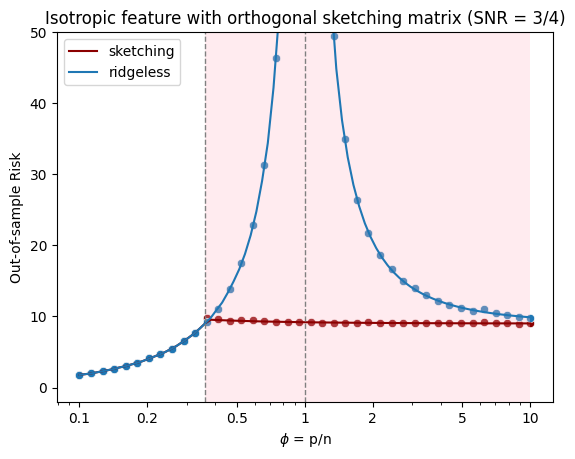

In [43]:
# Plot
ticks = [0.1, 0.2, 0.5, 1, 2, 5, 10]
labels = [i for i in ticks]

#ax = sns.scatterplot(x=m/n_train, y=mse_emp, label = "SNR = 1.00 (emp)")
ax = sns.scatterplot(x=emp_phi, y=emp_sketch_risk, color='darkred')
ax = sns.scatterplot(x=emp_phi, y=emp_ridgeless_risk)
ax = sns.lineplot(x=phi, y=sketch_risk, color='darkred', label="sketching")
ax = sns.lineplot(x=phi, y=ridgeless_risk, label="ridgeless")

ax.axvline(x=1, color="grey", linestyle='dashed', linewidth=1)
ax.axvspan((alpha**2 / (alpha**2 + sigma**2)), 10, facecolor='pink', alpha=0.3, **dict())
ax.axvline(x=(alpha**2 / (alpha**2 + sigma**2)), color="grey", linestyle='dashed', linewidth=1)


ax.set_ylim(-2, 50)
# ax.axvline(x=1, color="grey", linestyle='dashed', linewidth=1)
ax.set_xscale('log')
ax.set(xticks = ticks, xticklabels = labels)

ax.set_title("Isotropic feature with orthogonal sketching matrix (SNR = 3/4)")
ax.set_ylabel("Out-of-sample Risk")
ax.set_xlabel(r"$\phi$ = p/n")

### SNR > 1

In [14]:
alpha = 6.0
sigma = 2.0

n_pts = 40                 # number of points in the graph for visualizing empirical results (dots)
n_pts_asymp = 120          # number of points in the graph for visualizing theorem 3.2 (line)

In [15]:
%%time
pp = np.zeros(n_pts, dtype=int)
mse_original = np.zeros(n_pts)
mse_sketch = np.zeros(n_pts)
opt_m = np.zeros(n_pts, dtype=int)

phi_range = list(np.logspace(-1, 1, n_pts))
for i, pphi in enumerate(phi_range):
    pp[i] = int(pphi * n_train)
    mse_oos_sketch = []
    opt_m[i], case = optimal_m(alpha, sigma, n_train, pp[i])

    # Sketching
    if case == 3: 
        mse_oos_sketch = Parallel(n_jobs=-1)(delayed(simulate_ridgeless)(n_train, pp[i], alpha, sigma, seed+j, n_test=n_test) for j in range(n_sim))
    else:
        mse_oos_sketch = Parallel(n_jobs=-1)(delayed(simulate_sketching)(n_train, pp[i], opt_m[i], alpha, sigma, seed+j, is_orthogonal=True, n_test=n_test) for j in range(n_sim))

    mse_sketch[i] = np.mean(mse_oos_sketch)
    
    print(pphi, opt_m[i], mse_sketch[i])

    # Non-sketching
    mse_oos = []
    mse_oos = Parallel(n_jobs=-1)(delayed(simulate_ridgeless)(n_train, pp[i], alpha, sigma, seed+j, n_test=n_test) for j in range(n_sim))

    mse_original[i] = np.mean(mse_oos)

0.1 400 0.44985247015368585
0.11253355826007651 400 0.5057632441231018
0.12663801734674032 400 0.5717468139491269
0.14251026703029981 400 0.66748703158407
0.160371874375133 400 0.7674340992189559
0.18047217668271703 400 0.871383586491492
0.20309176209047358 400 1.0245140378268243
0.22854638641349906 400 1.1782387234458864
0.2571913809059345 400 1.3584434724770362
0.289426612471675 400 1.63943510093566
0.3257020655659783 400 1.9281648206638324
0.3665241237079628 400 2.2971114458330053
0.41246263829013524 400 2.753098218687996
0.46415888336127786 400 3.479181193015403
0.5223345074266842 400 4.3817131912819764
0.5878016072274912 400 5.721840551294108
0.6614740641230149 400 7.826895618450776
0.7443803013251689 400 11.593160427563848
0.8376776400682918 223 20.07199622041985
0.9426684551178852 251 20.267166739774098
1.0608183551394483 282 19.962456078889694
1.1937766417144364 317 20.003281697501357
1.3433993325989002 358 19.95586268853938
1.5117750706156623 400 20.240577385268853
1.701254279

In [18]:
import pandas as pd

df = pd.DataFrame()
df['phi_range'] = phi_range
df['mse_sketch'] = mse_sketch
df['mse_original'] = mse_original

In [20]:
# Theorem 3.6 case (ii)
pp = np.zeros(n_pts_asymp, dtype=int)
mse_original = np.zeros(n_pts_asymp)
mse_sketch = np.zeros(n_pts_asymp)
opt_m = np.zeros(n_pts_asymp)
case = np.zeros(n_pts_asymp)

phi = list(np.logspace(-1, 1, n_pts_asymp))
for i, pphi in enumerate(phi):
    pp[i] = int(pphi * n_train)

    opt_m[i], case[i] = optimal_m(alpha, sigma, n_train, pp[i])

    mse_original[i] = asy_risk(n_train, pp[i], alpha, sigma)

    if case[i] == 3: 
        mse_sketch[i] = mse_original[i]
    else:
        mse_sketch[i] = asy_risk_sketching(n_train, pp[i], opt_m[i], alpha, is_orthogonal=True, sigma=sigma)

In [21]:
import os
import json

data = {
    "s_orthogonal": 1,
    "n_train": n_train,
    "alpha": alpha,
    "sigma": sigma,
    "seed": seed,
    "emp_phi": phi_range,
    "emp_sketch_risk": df['mse_sketch'].to_list(),
    "emp_ridgeless_risk": df['mse_original'].to_list(),
    "phi": phi,
    "sketch_risk": mse_sketch.tolist(),
    "ridgeless_risk": mse_original.tolist()
}

save_path = "../result/thm3.6_vary_np_S_orthogonal/" 
if not os.path.isdir(save_path):
    os.makedirs(save_path)

# Save
with open(save_path + 'alpha' + str(alpha) + 'sigma' + str(sigma) + '_nsim' + str(n_sim) + '.json', 'w') as file:
    json.dump(data, file,indent=4)

In [22]:
alpha, sigma, emp_phi, emp_sketch_risk, emp_ridgeless_risk, phi, sketch_risk, ridgeless_risk = load_files('thm3.6_vary_np_S_orthogonal/alpha6.0sigma2.0_nsim500.json')

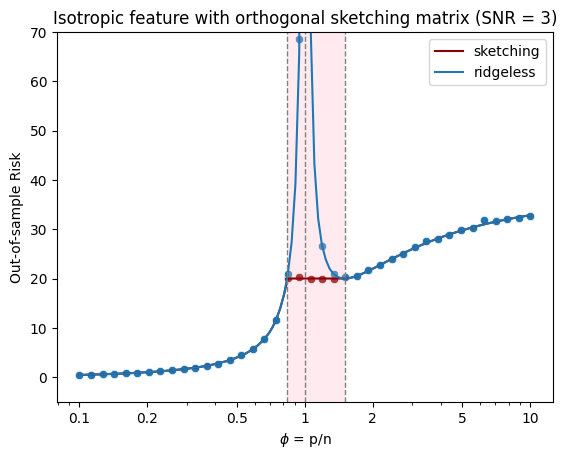

In [23]:
# Plot
ticks = [0.1, 0.2, 0.5, 1, 2, 5, 10]
labels = [i for i in ticks]

#ax = sns.scatterplot(x=m/n_train, y=mse_emp, label = "SNR = 1.00 (emp)")
ax = sns.scatterplot(x=emp_phi, y=emp_sketch_risk, color='darkred')
ax = sns.scatterplot(x=emp_phi, y=emp_ridgeless_risk)
ax = sns.lineplot(x=phi, y=sketch_risk, color='darkred', label="sketching")
ax = sns.lineplot(x=phi, y=ridgeless_risk, label="ridgeless")

ax.axvline(x=1, color="grey", linestyle='dashed', linewidth=1)
ax.axvspan((1 - sigma/(2*alpha)), alpha/(alpha - sigma), facecolor='pink', alpha=0.3, **dict())
ax.axvline(x=(1 - sigma/(2*alpha)), color="grey", linestyle='dashed', linewidth=1)
ax.axvline(x=alpha/(alpha - sigma), color="grey", linestyle='dashed', linewidth=1)

ax.set_ylim(-5, 70)
# ax.axvline(x=1, color="grey", linestyle='dashed', linewidth=1)
ax.set_xscale('log')
ax.set(xticks = ticks, xticklabels = labels)

ax.set_title("Isotropic feature with orthogonal sketching matrix (SNR = 3)")
ax.set_ylabel("Out-of-sample Risk")
ax.set_xlabel(r"$\phi$ = p/n")
plt.show()

# Plotting

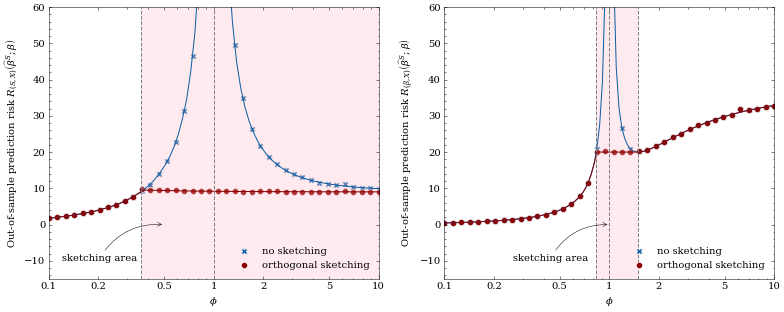

In [3]:
from sklearn.base import RegressorMixin

import numpy as np
import seaborn as sns

from scipy.stats import ortho_group # othogonal matrix

import os
import json
# Load
import codecs

import scienceplots
import matplotlib.pyplot as plt 

def load_files(file_loc):
    file = json.loads(codecs.open('../result/' + file_loc, 'r').read())
    emp_phi = file["emp_phi"]
    emp_sketch_risk = file["emp_sketch_risk"]
    emp_ridgeless_risk = file["emp_ridgeless_risk"]
    
    phi = file["phi"]
    sketch_risk = file["sketch_risk"]
    ridgeless_risk = file["ridgeless_risk"]

    return file["alpha"], file["sigma"], emp_phi, emp_sketch_risk, emp_ridgeless_risk, phi, sketch_risk, ridgeless_risk


with plt.style.context(['science', 'no-latex', 'std-colors']):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))

    # Plot
    ticks = [0.1, 0.2, 0.5, 1, 2, 5, 10]
    labels = [i for i in ticks]

    alpha, sigma, emp_phi, emp_sketch_risk, emp_ridgeless_risk, phi, sketch_risk, ridgeless_risk = load_files('thm3.6_vary_np_S_orthogonal/alpha3sigma4_nsim500.json')
    
    ax[0] = sns.scatterplot(x=emp_phi, y=emp_ridgeless_risk, ax=ax[0], marker='X', label="no sketching")
    ax[0] = sns.scatterplot(x=emp_phi, y=emp_sketch_risk, color='darkred', ax=ax[0], label="orthogonal sketching")
    ax[0] = sns.lineplot(x=phi, y=ridgeless_risk, ax=ax[0])
    ax[0] = sns.lineplot(x=phi, y=sketch_risk, color='darkred', ax=ax[0])

    ax[0].axvline(x=1, color="grey", linestyle='dashed', linewidth=1)
    ax[0].axvspan((alpha**2 / (alpha**2 + sigma**2)), 10, facecolor='pink', alpha=0.3, **dict())
    ax[0].axvline(x=(alpha**2 / (alpha**2 + sigma**2)), color="grey", linestyle='dashed', linewidth=1)
    
    ax[0].annotate('sketching area', xy=(0.5,0), xytext=(0.12, -10), arrowprops={'arrowstyle': '->', 'lw': 0.5, 'ec': 'black', "connectionstyle":'arc3,rad=-0.3'})
                   
    
    ax[0].set_ylim(-15, 60)
    ax[0].set_xlim(0.1, 10)
    ax[0].set_xscale('log')
    ax[0].set(xticks = ticks, xticklabels = labels)
    ax[0].legend(loc='lower right')

    #ax[0].set_title("Isotropic features, orthogonal sketching matrix, SNR = 0.75")
    ax[0].set_ylabel(r"Out-of-sample prediction risk $R_{(S, X)}\left(\widehat{\beta}^S ; \beta\right)$")
    ax[0].set_xlabel(r"$\phi$")


    alpha, sigma, emp_phi, emp_sketch_risk, emp_ridgeless_risk, phi, sketch_risk, ridgeless_risk = load_files('thm3.6_vary_np_S_orthogonal/alpha6.0sigma2.0_nsim500.json')

    ax[1] = sns.scatterplot(x=emp_phi, y=emp_ridgeless_risk, marker='X', label="no sketching", ax=ax[1])
    ax[1] = sns.scatterplot(x=emp_phi, y=emp_sketch_risk, color='darkred', label="orthogonal sketching")
    ax[1] = sns.lineplot(x=phi, y=ridgeless_risk)
    ax[1] = sns.lineplot(x=phi, y=sketch_risk, color='darkred')

    ax[1].axvline(x=1, color="grey", linestyle='dashed', linewidth=1)
    ax[1].axvspan((1 - sigma/(2*alpha)), alpha/(alpha - sigma), facecolor='pink', alpha=0.3, **dict())
    ax[1].axvline(x=(1 - sigma/(2*alpha)), color="grey", linestyle='dashed', linewidth=1)
    ax[1].axvline(x=alpha/(alpha - sigma), color="grey", linestyle='dashed', linewidth=1)
    
    ax[1].annotate('sketching area', xy=(1, 0), xytext=(0.26, -10), arrowprops={'arrowstyle': '->', 'lw': 0.5, 'ec': 'black', "connectionstyle":'arc3,rad=-0.3'})
    
                   #arrowprops = dict(facecolor = 'darkred', shrink = 0.03),)

    ax[1].set_ylim(-15, 60)
    ax[1].set_xlim(0.1, 10)
    ax[1].set_xscale('log')
    ax[1].set(xticks = ticks, xticklabels = labels)
    ax[1].legend(loc='lower right')
    #ax[1].set_title("Isotropic features, i.i.d. sketching matrix, SNR = 3.0")
    ax[1].set_ylabel(r"Out-of-sample prediction risk $R_{(\beta, X)}\left(\widehat{\beta}^S ; \beta\right)$")
    ax[1].set_xlabel(r"$\phi$")

    plt.savefig('figure2.pdf', dpi=400, facecolor='w', edgecolor='w', pad_inches=None)
    plt.show()


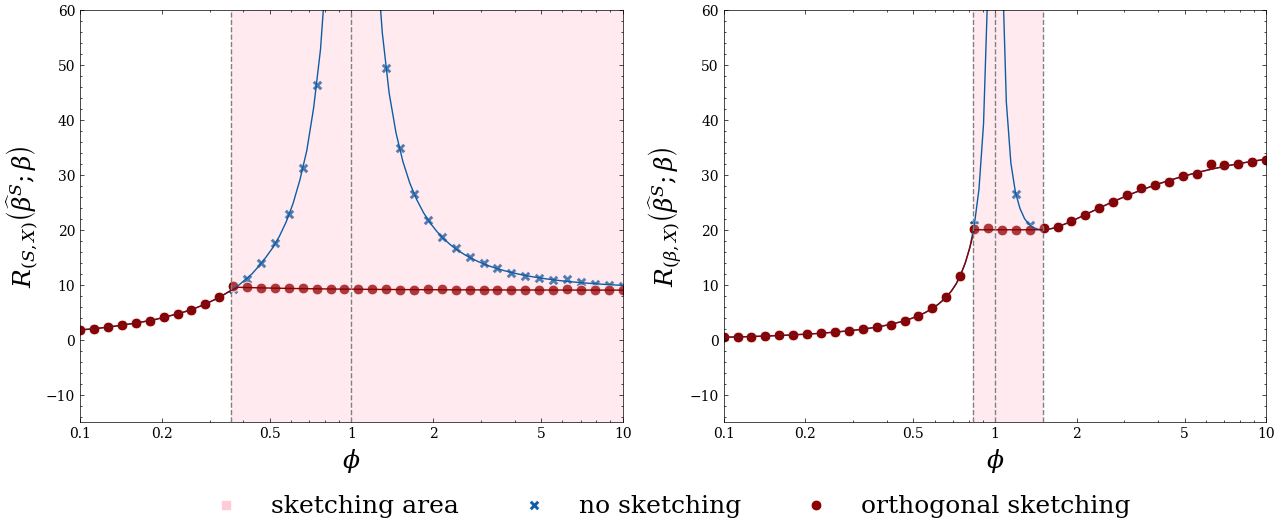

In [20]:
from sklearn.base import RegressorMixin

import numpy as np
import seaborn as sns

from scipy.stats import ortho_group # othogonal matrix

import os
import json
# Load
import codecs

import scienceplots
import matplotlib.pyplot as plt 

def load_files(file_loc):
    file = json.loads(codecs.open('../result/' + file_loc, 'r').read())
    emp_phi = file["emp_phi"]
    emp_sketch_risk = file["emp_sketch_risk"]
    emp_ridgeless_risk = file["emp_ridgeless_risk"]
    
    phi = file["phi"]
    sketch_risk = file["sketch_risk"]
    ridgeless_risk = file["ridgeless_risk"]

    return file["alpha"], file["sigma"], emp_phi, emp_sketch_risk, emp_ridgeless_risk, phi, sketch_risk, ridgeless_risk


with plt.style.context(['science', 'no-latex', 'std-colors']):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))

    # Plot
    ticks = [0.1, 0.2, 0.5, 1, 2, 5, 10]
    labels = [i for i in ticks]

    alpha, sigma, emp_phi, emp_sketch_risk, emp_ridgeless_risk, phi, sketch_risk, ridgeless_risk = load_files('thm3.6_vary_np_S_orthogonal/alpha3sigma4_nsim500.json')
    ax[0] = sns.scatterplot(x=[0.5], y=[-100], marker='s', color='pink', s=60, alpha=0.8, label="sketching area", ax=ax[0])
    ax[0] = sns.scatterplot(x=emp_phi, y=emp_ridgeless_risk, ax=ax[0], s=60, marker='X', label="no sketching")
    ax[0] = sns.scatterplot(x=emp_phi, y=emp_sketch_risk, color='darkred', s=60, ax=ax[0], label="orthogonal sketching")
    ax[0] = sns.lineplot(x=phi, y=ridgeless_risk, ax=ax[0])
    ax[0] = sns.lineplot(x=phi, y=sketch_risk, color='darkred', ax=ax[0])

    #ax[0] = sns.scatterplot(x=emp_phi, y=emp_ridgeless_risk, marker='X', label="no sketching", ax=ax[0])
    ax[0].axvline(x=1, color="grey", linestyle='dashed', linewidth=1)
    ax[0].axvspan((alpha**2 / (alpha**2 + sigma**2)), 10, facecolor='pink', alpha=0.3, **dict())
    ax[0].axvline(x=(alpha**2 / (alpha**2 + sigma**2)), color="grey", linestyle='dashed', linewidth=1)
    
    ax[0].set_ylim(-15, 60)
    ax[0].set_xlim(0.1, 10)
    ax[0].set_xscale('log')
    ax[0].set(xticks = ticks, xticklabels = labels)
    ax[0].legend(loc='lower right')

    #ax[0].set_title("Isotropic features, orthogonal sketching matrix, SNR = 0.75")
    ax[0].set_ylabel(r"$R_{(S, X)}\left(\widehat{\beta}^S ; \beta\right)$", fontsize=18)
    ax[0].set_xlabel(r"$\phi$", fontsize=18)


    alpha, sigma, emp_phi, emp_sketch_risk, emp_ridgeless_risk, phi, sketch_risk, ridgeless_risk = load_files('thm3.6_vary_np_S_orthogonal/alpha6.0sigma2.0_nsim500.json')

    ax[1] = sns.scatterplot(x=emp_phi, y=emp_ridgeless_risk, marker='X', s=60, label="no sketching", ax=ax[1])
    ax[1] = sns.scatterplot(x=emp_phi, y=emp_sketch_risk, color='darkred', s=60, label="orthogonal sketching")
    ax[1] = sns.lineplot(x=phi, y=ridgeless_risk)
    ax[1] = sns.lineplot(x=phi, y=sketch_risk, color='darkred')

    ax[1].axvline(x=1, color="grey", linestyle='dashed', linewidth=1)
    ax[1].axvspan((1 - sigma/(2*alpha)), alpha/(alpha - sigma), facecolor='pink', alpha=0.3, **dict())
    ax[1].axvline(x=(1 - sigma/(2*alpha)), color="grey", linestyle='dashed', linewidth=1)
    ax[1].axvline(x=alpha/(alpha - sigma), color="grey", linestyle='dashed', linewidth=1)
    
    ax[1].set_ylim(-15, 60)
    ax[1].set_xlim(0.1, 10)
    ax[1].set_xscale('log')
    ax[1].set(xticks = ticks, xticklabels = labels)
    ax[1].legend(loc='lower right')
    #ax[1].set_title("Isotropic features, i.i.d. sketching matrix, SNR = 3.0")
    ax[1].set_ylabel(r"$R_{(\beta, X)}\left(\widehat{\beta}^S ; \beta\right)$", fontsize=18)
    ax[1].set_xlabel(r"$\phi$", fontsize=18)

    ax[0].get_legend().remove()
    ax[1].get_legend().remove()
    handles, labels = ax[0].get_legend_handles_labels()
     
    #handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.52, -0.1), ncol = 4, prop={'size':18})
    plt.tight_layout()

    plt.savefig('figure2.pdf', dpi=400, facecolor='w', edgecolor='w', pad_inches=None)
    plt.show()
